In [1]:
# Data Manipulation Modules
import pandas as pd
import numpy as np
import scipy as sp
import numpy as np
import math 
import scipy.stats as stats
import fancyimpute 
from collections import Counter

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as ms

#Multiple Imputation
import sklearn

# Managing Warnings 
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
LoadData = "../data/ExpSepPos.csv"

df = pd.read_csv(LoadData, index_col = False)

random_state = 1

In [3]:
print(df.shape)
print(max(df['GameId']))
print(min(df['GameId']))
df.head()

(53710, 31)
2020020200
2017090700


,GameId,PlayId,Season,Team,Receiver,Nearest_Defender,Nearest_Def_Position,Opp,Wk,Qtr,...,Air_Dist,Air_Time,TTT,Separation,QB_Separation,QBP,QB_Scramble_Yds,Receiver_Dist_From_Sideline,QB_Speed_at_Pass,EZ_Dist
0,2017102910,2814,2017,PIT,JuJu Smith-Schuster,Quandre Diggs,SS,DET,8,3,...,33.119846,1.539,2.756,1.785385,2.084347,0,4.12,26.303329,1.145455,37.540001
1,2018112509,2475,2018,PIT,JuJu Smith-Schuster,Bradley Roby,CB,DEN,12,3,...,37.510450,2.202,2.436,2.674790,1.540033,1,7.09,12.303331,3.763636,40.230003
2,2017111208,2731,2017,LA,Robert Woods,Johnathan Joseph,CB,HOU,10,3,...,52.871040,2.633,3.135,3.966674,3.386576,0,7.52,17.230000,1.247727,58.880001
3,2019120800,2777,2019,ATL,Olamide Zaccheaus,Donte Jackson,CB,CAR,14,3,...,49.233444,3.018,2.771,0.910220,2.814427,0,5.20,19.433328,1.329546,56.439999
4,2019101310,1630,2019,NYJ,Robby Anderson,Jeff Heath,SS,DAL,6,2,...,46.187710,2.636,3.003,1.676305,1.471224,1,6.58,15.103330,3.477273,57.060001


Our Dataset spans 3 years (2017-2020) and includes regular and postseason games. We have a total of 53,710 total passes with non-null receiver separations to work with. 

In [4]:
# Describing all the Numerical Features
df.describe()
COLS = df.columns.to_list()

## Dropping non-relevant features 

Right off the bat, I think a lot the variables in this dataset will not be useful in predicting reciever separation. Also, there are a lot features in this set that describe the outcome of the event. These features (Pass Yards, TD, INT) cannot be used in prediction. For features that I am skeptical of, but not sure about their effect, I will leave alone, otherwise I will drop all non-essential features below.

In [5]:
IrrelevantCols = ['GameId', 'PlayId', 'Season', 'Wk', 'Cmp', 'Team', 'Receiver', 'Nearest_Defender', 
                  'Opp', 'Wk', 'Cmp', 'Pass Yds', 'QB_Speed_at_Pass', 'QB_Scramble_Yds','TD', 'INT', 
                  'Comp_Prob']

# Drop all irrelevant columns and output variable (separation)
Features = df.drop(IrrelevantCols, axis = 1)

#Create 1-dimensional array of Target variable (separation)
Target = df['Separation']

#Output top 5 rows of Features Dataframe
cols = len(Features.columns)
print('We are left with ' + str(cols) + ' features to help with prediction')
Features.head()


We are left with 16 features to help with prediction


,Nearest_Def_Position,Qtr,Time,Down,To Go,Receiver_Location,Cushion,Air_Yds,Air_Dist,Air_Time,TTT,Separation,QB_Separation,QBP,Receiver_Dist_From_Sideline,EZ_Dist
0,SS,3,3:15,3,9,Slot,3.66,24.54,33.119846,1.539,2.756,1.785385,2.084347,0,26.303329,37.540001
1,CB,3,10:47,1,10,Wide,2.66,27.23,37.510450,2.202,2.436,2.674790,1.540033,1,12.303331,40.230003
2,CB,3,9:36,2,8,Wide,10.23,42.88,52.871040,2.633,3.135,3.966674,3.386576,0,17.230000,58.880001
3,CB,3,6:45,3,8,Wide,6.74,39.44,49.233444,3.018,2.771,0.910220,2.814427,0,19.433328,56.439999
4,SS,2,3:46,1,10,Wide,3.23,39.06,46.187710,2.636,3.003,1.676305,1.471224,1,15.103330,57.060001


In [6]:
Features.to_pickle("../data/raw.pkl")

Features = Features.drop('Separation', axis = 1)

# Target Variable (Separation)

Let's take a look at our target variable, Reciever Separation



The Kurtosis of the distribution of the target variable is 1.7
The Skew of the distribution of the target variable is 1.2


count    53710.000000
mean         3.244240
std          2.435761
min          0.020000
25%          1.292652
50%          2.613341
75%          4.589033
max         19.226980
Name: Separation, dtype: float64

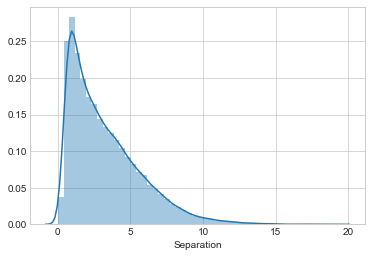

In [7]:
# How Normally Distributed is our Output Variable (Separation)

plt.style.use('seaborn-whitegrid')
Fig = sns.distplot(df['Separation'])

K = round(stats.kurtosis(df['Separation']),1)
S = round(stats.skew(df['Separation']), 1)
p_value = stats.shapiro(df['Separation'])[1]
    
print('\n')
print('The Kurtosis of the distribution of the target variable is ' + str(K))
print('The Skew of the distribution of the target variable is ' + str(S))

df['Separation'].describe()


As we can see, our data is **skewed to the right**, or positively skewed, and resembles an [inverse gaussian distribution.](https://en.wikipedia.org/wiki/Inverse_Gaussian_distribution)

Based on my understanding of the game of football, the only time we would expect receiver separations to be greater than 10 yards, are in instances where the targeted player is not a current threat to gain yards (passes targeting receivers behind the line of scrimmage) OR blatant busts in coverage. For the sake of this model, however, I am not interested in predicting these results. I am more interested in being able to predict separations in instances where there are defenders close-by and the receiver must do something to gain separation.

## Detecting and Removing Outliers in the Target Variable

Since the distribution of separation is so non-normal, I decided to use the Tukey method (Tukey JW., 1977) to detect ouliers, which is based on quartiles as opposed to using standard deviations or anything of the like. 
First we find the interquartile range, comprised between the 1st and 3rd quartile of the distribution (IQR). An outer fence outlier is any Separation value outside the IQR +/- 1 outlier steps. 1 Outlier step is defined as 3 times the interquartile range.

In [8]:
# 1st quartile (25%)
Q1 = np.percentile(df['Separation'], 25)
# 3rd quartile (75%)
Q3 = np.percentile(df['Separation'],75)
# Interquartile range (IQR)
IQR = Q3 - Q1
        
# outlier step
outlier_step = 3 * IQR

#Upper outer fence
outlier_step + Q3

#Tukey's Outer Upper Fence
Upper_Fence = outlier_step + Q3
Upper_Fence

14.478175490000002

In this case, the only outliers exist beyond the 3rd Quartile (because there are no outliers below Q1), which is **14.5 yards**. 

Since we do not want to predict these situations, I will now drop all rows with a separation value above 14.5 yards. 

In [9]:
df = df[df['Separation'] <= Upper_Fence]

In [10]:
left = len(df)
print('We dropped ' + str(53710-left) + ' rows with a separation over 14.5 yards, or ' + str(round(((53710-left)/53710)*100,2) )+'% of our dataset')

We dropped 49 rows with a separation over 14.5 yards, or 0.09% of our dataset


## Missing Values

How many missing (NaN, null) values do we have in out dataset?

In [11]:
def missing_values_table(df):
    mv = pd.DataFrame({'Feature':df.columns, 'Missing Values':[df[col].isnull().sum() for col in df.columns]})
    mv['Percentage'] = mv['Missing Values']*100.0/len(df)
    mv = mv.loc[mv['Missing Values'] > 0].sort_values('Percentage', ascending=False).round(1).set_index('Feature')
    return mv

missing_values_table(Features)

,Missing Values,Percentage
Feature,,
Cushion,14125,26.3
Receiver_Location,108,0.2
Time,33,0.1


## What's up with these missing cushion values?

Of the 14125 missing cushion values, how many were from targets from receivers who lined up in the backfield?

In [12]:
Cush = df[df['Cushion'].isna()]
Cush['Receiver_Location'].value_counts()

Backfield    9826
Slot         2739
Tight        1329
Wide          113
Name: Receiver_Location, dtype: int64

In [13]:
Backfield = df[(df['Receiver_Location'] == 'Backfield')][['Cushion', 'Separation']]
print('There were ' + str(len(Backfield)) + ' plays where the player who lined up in the backfield was targeted')
print('The average Cushion of a player who lines up in the Backfield is ' + str(Backfield['Cushion'].mean()))
print('The average Separation of a player who lines up in the Backfield is ' + str(round(Backfield['Separation'].mean(), 2)))


There were 9826 plays where the player who lined up in the backfield was targeted
The average Cushion of a player who lines up in the Backfield is nan
The average Separation of a player who lines up in the Backfield is 4.75


Every target to a player that lined up in the *'Backfield'* in this dataset has a **null cushion value**. 

This makes sense, as they are far from the line of scrimmage, often behind, or to the side of the QB at the time of snap, and roughly 5-10 yards behind the line of scrimmage when the ball is snapped, making it nearly impossible to determine who is covering them, if anyone specific at all. 

If all of the Backfield targets are missing a cushion value, this means that this type of data is *Missing Not at Random* ([relevant wiki](https://en.wikipedia.org/wiki/Missing_data#Missing_not_at_random)). With data that is missing Not at Random, it is not 'ignorable' since removing all of these rows would drastically change the distribution of Separation values. 

That being said, the goal of this project is try to predict a players separation as accurately as possible, and if we remove just the backfield targets, we don't necessarily lose any insight in how to predict Separation for non-backfield targets. 

## Ways to deal with missing Cushion values 
 1. Impute the missing values
     - Replace missing values with a summary statistic (like a mean/median)
         - This would introduce a lot bias into the distribution of Cushion in the whole data set (25% would be one number)
     - Use something like kNN (K-nearest neighbors) or other ML model to predict Cushion 
         - 'Backfield' rows have 0 cushion values
         - We have to use other Features in the dataset to draw from
 2. Remove all rows where the receiver location is 'Backfield' 
     - This will remove ~10,000 rows, losing data is never ideal, but sometimes necessary 
     - Predicting non-backfield targets will likely be more accurate after removing these rows
     - Remember our goal: creating a way to compare receivers
         - Since RBs are the primary receiver out of the backfield, I am not as concerned about their ability to create separation

Let's take a look at the distribution of Separations grouped by Receiver Location to see if they are differences:

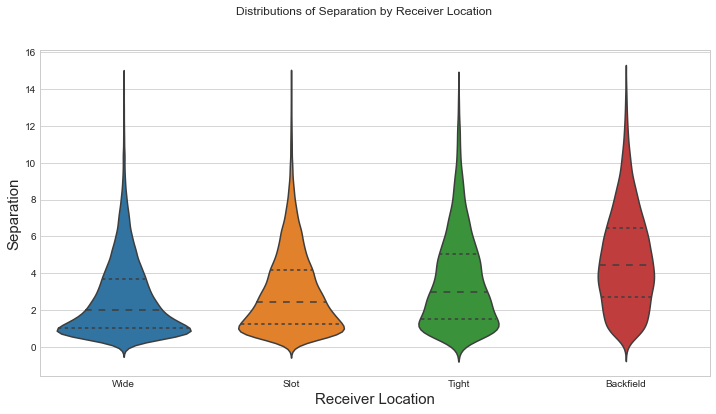

In [14]:
#Look at the distributions of Separation by Pre-Snap Receiver Location

fig, (ax2) = plt.subplots(figsize=(12,6))

fig.suptitle('Distributions of Separation by Receiver Location')
#sns.boxplot(x="Receiver_Location", y="Separation", data=df, ax = ax1, order=['Wide', 'Slot', 'Tight', 'Backfield'])
A =sns.violinplot(x="Receiver_Location", y="Separation", inner = 'quartile', data=df, ax = ax2, order=['Wide', 'Slot', 'Tight', 'Backfield'])

ax2.set_xlabel('Receiver Location', fontsize = 15)
A = ax2.set_ylabel('Separation', fontsize = 15)

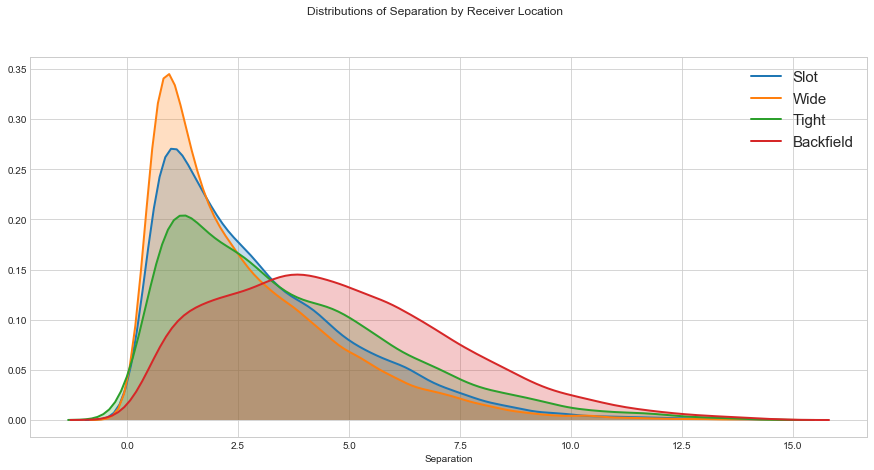

In [15]:
# List of four recevier locations to plot
RecLocations = list(df['Receiver_Location'].unique())

fig_dims = (15, 7)
fig, ax = plt.subplots(figsize=fig_dims)
fig.suptitle('Distributions of Separation by Receiver Location')

# Iterate through the four receiver locations
for loc in RecLocations:
    # Subset to the Receiver location
    subset = df[df['Receiver_Location'] == loc]
    
    # Draw the density plots
    sns.distplot(subset['Separation'], ax = ax, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 2},
                 label = loc)
    
A = ax.legend(loc=1, prop={'size': 15})

In [16]:
print('The mean separation of Backfield targets is ' + str(round(df[df['Receiver_Location'] == 'Backfield']['Separation'].mean(), 1)) + ' yards, +/- ' + str(round(df[df['Receiver_Location'] == 'Backfield']['Separation'].std(), 1))+ ' yards')
print('The mean separation of NON-Backfield targets is ' + str(round(df[df['Receiver_Location'] != 'Backfield']['Separation'].mean(), 1)) + ' yards, +/- ' + str(round(df[df['Receiver_Location'] != 'Backfield']['Separation'].std(), 1))+ ' yards')

The mean separation of Backfield targets is 4.7 yards, +/- 2.7 yards
The mean separation of NON-Backfield targets is 2.9 yards, +/- 2.2 yards



The average target separation for backfield targets is **~40% higher than non-backfield targets.**

This makes sense intuitively, as these receivers do not have pre-snap cushions, meaning that no one is lined up close to them at the time of snap.  Also, I am assuming that this is because targets to receivers in the backfield occur not as far down the field as non-backfield targets.

Let's check this to see if our assumptions are correct - 

*Are targets to receivers in the backfield shorter (less air yards) and therefore warrant more separation?*

In [17]:
print('Average Backfield Target: ' + str(round(df[df['Receiver_Location'] == 'Backfield']['Air_Yds'].mean(), 2)) + ' yards downfield')
print('Average Non-Backfield Target: ' + str(round(df[df['Receiver_Location'] != 'Backfield']['Air_Yds'].mean(), 2)) + ' yards downfield')

Average Backfield Target: 0.04 yards downfield
Average Non-Backfield Target: 10.06 yards downfield


### Dropping all rows for Targets in the Backfield

Since **all** of the cushion values are missing for targets to recievers who line up in the backfield, and they they usually are not indicative of anything the receiver is inherently doing to create separation, I am choosing to drop all rows targeting receivers who line up in the 'Backfield'

In [18]:
NB_Features = Features[Features['Receiver_Location'] != 'Backfield']
print(len(NB_Features))
missing_values_table(NB_Features)

43864


,Missing Values,Percentage
Feature,,
Cushion,4279,9.8
Receiver_Location,108,0.2
Time,33,0.1


## Drop Remaining rows from other Features

Since the Missing Receiver_Location, QB_Scramble_Yds, and Time rows represent ~0.2% of our data set (108 samples), we can comfortably drop those offending rows.

In [19]:
NB_Features = NB_Features[NB_Features['Receiver_Location'].notnull()]
#NB_Features = NB_Features[NB_Features['QB_Scramble_Yds'].notnull()]
NB_Features = NB_Features[NB_Features['Time'].notnull()]
print(len(NB_Features))
missing_values_table(NB_Features)

43755


,Missing Values,Percentage
Feature,,
Cushion,4189,9.6


We are left with 4182 misssing cushion values. 

These missing values, unlike the missing cushion values for 'Backfield' Targets, are [*'missing at random'*](https://en.wikipedia.org/wiki/Missing_data#Missing_at_random). There is nothing in the dataset that would indicate that these cushions can be inferred from another feature, so I want to look into a way to impute these values effectively and efficiently. 

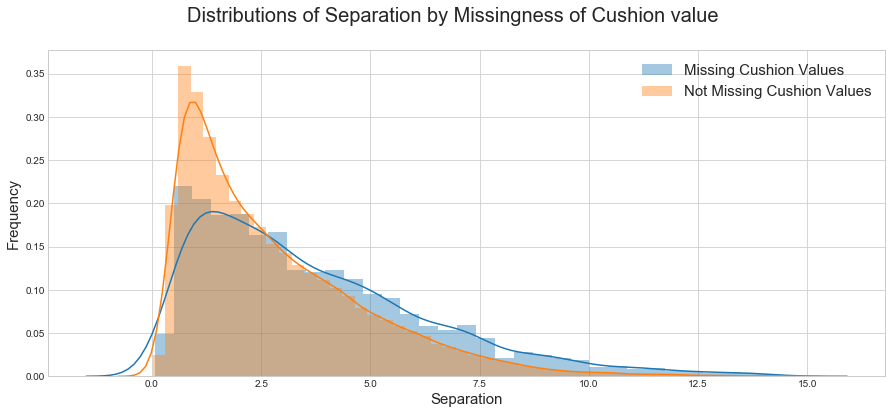

In [20]:
# List of two types of data to plot
DataTypes = ['Missing Cushion Values', 'Not Missing Cushion Values']

#Create dataframe with just non-Backfield targets
df_1 = df[df['Receiver_Location'] != 'Backfield']

#Separate dataframes into missing and non-missing Dataframes
M = df_1[df_1['Cushion'].isna()]
NM = df_1[df_1['Cushion'].notnull()]

fig_dims = (15, 6)
fig, ax = plt.subplots(figsize=fig_dims)
fig.suptitle('Distributions of Separation by Missingness of Cushion value', fontsize = 20)

# Iterate through the two datatypes (missing and non-missing)
for loc in DataTypes:
    # Subset to the DataType
    if loc == 'Missing Cushion Values':
        subset = M
    else:
        subset = NM
    
    # Draw the density plots
    sns.distplot(subset['Separation'], ax = ax, label = loc)
    ax.legend(loc=1, prop={'size': 15})
    ax.set_ylabel('Frequency', fontsize = 15)
    ax.set_xlabel('Separation', fontsize = 15)
    

In [21]:
print('Mean Separation w/ missing Cushion: ' + str(round(M['Separation'].mean(), 2)) + ' yards')
print('Mean Separation w/ non-missing Cushion: ' + str(round(NM['Separation'].mean(), 2)) + ' yards')

Mean Separation w/ missing Cushion: 3.7 yards
Mean Separation w/ non-missing Cushion: 2.81 yards


This makes intuitive sense, as we could imagine that targeting receviers who had no-one lined up across from them at the time of snap might lead to larger separation values. 

Let's look into this a little bit further to confirm our suspicions:

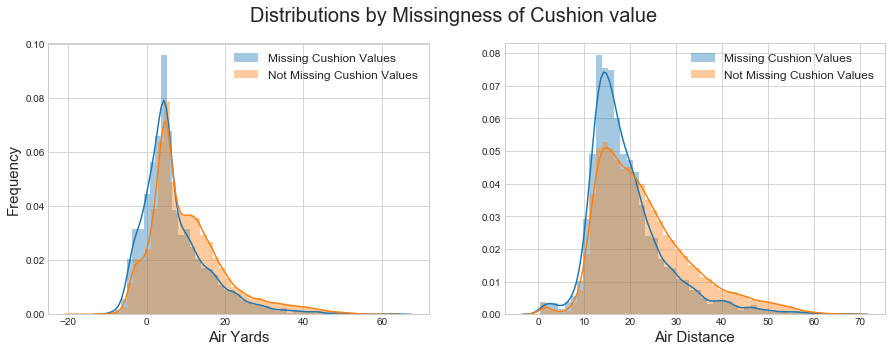

In [22]:
# List of two types of data to plot

fig_dims = (15, 6)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))
fig.suptitle('Distributions by Missingness of Cushion value', fontsize=20)


# Iterate through the four receiver locations
for loc in DataTypes:
    # Subset to the DataType
    if loc == 'Missing Cushion Values':
        subset = M
    else:
        subset = NM
    
    # Draw the density plots
    sns.distplot(subset['Air_Yds'], ax = ax1, label = loc)
    sns.distplot(subset['Air_Dist'], ax = ax2, label = loc)

    ax1.legend(loc=1, prop={'size': 12})
    ax2.legend(loc=1, prop={'size': 12})
    ax1.set_xlabel('Air Yards', fontsize=15)
    ax2.set_xlabel('Air Distance', fontsize=15)
    ax1.set_ylabel('Frequency', fontsize=15)

In [23]:
Miss = np.array([round(M['Air_Yds'].mean(), 1), round(NM['Air_Yds'].mean(), 1)])
NotMiss = np.array([round(M['Air_Dist'].mean(), 1), round(NM['Air_Dist'].mean(), 1)])
MNS = np.array(['Missing Cushion', 'Not Missing Cushion'])
df_Missingness = pd.DataFrame(); df_Missingness['Avg Air Yards']=pd.Series(Miss) ;df_Missingness['Avg Air Distance']=pd.Series(NotMiss)
df_Missingness['Missingness']=pd.Series(MNS) ;df_Missingness.set_index('Missingness')

,Avg Air Yards,Avg Air Distance
Missingness,,
Missing Cushion,7.2,19.3
Not Missing Cushion,10.4,23.1


Targets to players with no/missing cushion, they often are targeted **closer to the line of scrimmage** (7.2 yards downfield vs 10.4) and **closer to the QB** (19.3 yards as the crow flies vs. 23.1 yards) 

## Test to see if Distributions are statistically different from each other

We have suspicions that these two samples sets (rows with/without missing Cushion values) are statistically different, but let's confirm this in practice. In order to confirm that these two distributions are statistically different, I run a 2-sample Kolmogorov-Smirnov test [(ref)](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test)

If, in fact, they are different from each other, I must come up with a way to impute them that works to maintain each set's variance and distribution. If they are statistically the same, I can safely remove all offending rows.

In [24]:
from scipy.stats import ks_2samp

p_value = ks_2samp(M['Separation'], NM['Separation'])[1]

print('Our p-value for the K-S test to check for 2-sample similarity is ' + str(p_value))
print('Since our p-value < 0.05, we must find a way to deal with these values, we cannot remove them.')

Our p-value for the K-S test to check for 2-sample similarity is 2.3849552730047203e-72
Since our p-value < 0.05, we must find a way to deal with these values, we cannot remove them.


## Feature Engineering: Missing Cushion

Before we deal with the missing cushion values, I beleive that these targets are so distinct from the non-missing cushion targets that their 'missigness' could be insightful tp predicting separation. So, to this end, I will now create a feature called **'missing_cushion'** that is equal to 1 when the playet was missing a cushion value.

In [25]:
# Create new column to indicate plater is missing cushion
NB_Features['missing_cushion'] = 0
NB_Features['missing_cushion'].loc[NB_Features['Cushion'].isna()] = 1
NB_Features['missing_cushion'].sum()

4189

I want to also see if there is a cutoff value where a cushion value is so high, that it behaves like no cushion at all

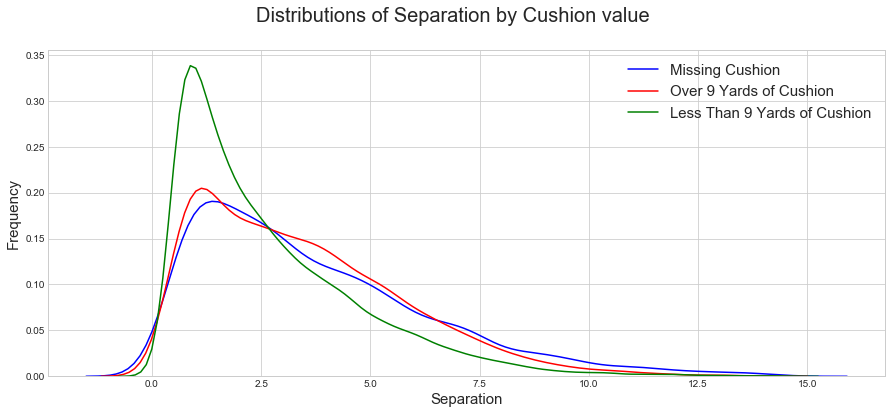

In [26]:
#Create dataframe with just non-Backfield targets
df_1 = df[df['Receiver_Location'] != 'Backfield']

#Separate dataframes into missing and non-missing Dataframes
M = df_1[df_1['Cushion'].isna()]
Over9 = df_1[df_1['Cushion'] >= 9]
Under9 = df_1[df_1['Cushion'] < 9]

fig_dims = (15, 6)
fig, ax = plt.subplots(figsize=fig_dims)
fig.suptitle('Distributions of Separation by Cushion value', fontsize = 20)

sns.distplot( M['Separation'] , color="blue", label="Missing Cushion", hist = False)
sns.distplot( Over9['Separation'] , color="red", label="Over 9 Yards of Cushion", hist = False)
sns.distplot( Under9['Separation'], color = 'green', label = 'Less Than 9 Yards of Cushion', hist = False)


ax.legend(prop={'size': 15}, )
ax.set_ylabel('Frequency', fontsize = 15)
A = ax.set_xlabel('Separation', fontsize = 15) 

After iterating through various cutoff values, it appears as though targets with **no cushion** behave very similarly to targets with **9+ yards** of cushion. Let's do a t-test to see if these two datasets are, in fact, statistically indiscernable. 

In [27]:
from scipy import stats

p_value = stats.ks_2samp(M['Separation'], Over9['Separation'])[1]

print('Our p-value for the K-S test to check for 2-sample similarity is ' + str(p_value))
print('Since our p-value > 0.05, it is the case that these two distributions are statistically indiscernable')

Our p-value for the K-S test to check for 2-sample similarity is 1.0
Since our p-value > 0.05, it is the case that these two distributions are statistically indiscernable


### Methods of Imputation

Now, we must impute these missing cushion values. Here's a breakdown of what we can do:

1. Replace all missing Cushion values with a summary statistic (mean/median) of Cushion
    - **Pros**: Simple, understandable, and fast
    - **Cons**: Since we are replacing ~10% of our data, this will severely bias our distribution and negatively affect our train/validation accuracies
2. Single Imputation from Regression (kNN, Neural Networks)
    - **Pros**: Introduces less bias than mean/median imputation, is still relatively simple
    - **Cons**: Slower, still does not generate entries that accurately reflect the distribution of the underlying data
3. Multiple Imputation from Chained Equations (MICE)
    - **Pros**: Most accurate, creates multiple imputations and analyzes pool of possible choice to create imputation
    - **Cons**: Slowest and less simple than single imputation
    
    
I am looking to create the most accurate prediction of Separation as I can, so I am choosing **MICE** [(reference)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3074241/)

In [28]:
#MICE cannot work with categorical features, so we must encode them first

#Transform Categorical Features to One-Hot Encoded Binary Variables
NB_Features_encoded = NB_Features.drop('Time', axis = 1)

NB_Features_encoded = pd.get_dummies(NB_Features_encoded)

NB_Features_encoded.head()

,Qtr,Down,To Go,Cushion,Air_Yds,Air_Dist,Air_Time,TTT,QB_Separation,QBP,...,Nearest_Def_Position_NT,Nearest_Def_Position_OLB,Nearest_Def_Position_S,Nearest_Def_Position_SAF,Nearest_Def_Position_SS,Nearest_Def_Position_TE,Nearest_Def_Position_WR,Receiver_Location_Slot,Receiver_Location_Tight,Receiver_Location_Wide
0,3,3,9,3.66,24.54,33.119846,1.539,2.756,2.084347,0,...,0,0,0,0,1,0,0,1,0,0
1,3,1,10,2.66,27.23,37.510450,2.202,2.436,1.540033,1,...,0,0,0,0,0,0,0,0,0,1
2,3,2,8,10.23,42.88,52.871040,2.633,3.135,3.386576,0,...,0,0,0,0,0,0,0,0,0,1
3,3,3,8,6.74,39.44,49.233444,3.018,2.771,2.814427,0,...,0,0,0,0,0,0,0,0,0,1
4,2,1,10,3.23,39.06,46.187710,2.636,3.003,1.471224,1,...,0,0,0,0,1,0,0,0,0,1


In [29]:
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer 
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer


#Create minimum value to create bounds for imputation
min_val = min(NB_Features['Cushion'])
max_val = max(NB_Features['Cushion'])


MICE_imputer = IterativeImputer(initial_strategy="median", 
                                max_iter = 100, #How many different imputations will be made? #Higher 
                                random_state = random_state, 
                                n_nearest_features = 7, #Use only the 7 nea
                                sample_posterior = True, 
                                skip_complete = True, 
                                min_value =  min_val, 
                                max_value = max_val)

NB_Features_enc_imp = MICE_imputer.fit_transform(NB_Features_encoded)

Cush_Fill = NB_Features_enc_imp[:,3]
NB_Features['Cushion'] = Cush_Fill

#Check how many null values there are
sum(NB_Features['Cushion'].isna())

0

In [30]:
Missing_df = NB_Features.loc[NB_Features['missing_cushion'] == 1]
Not_Missing_df = NB_Features.loc[NB_Features['missing_cushion'] == 0]           

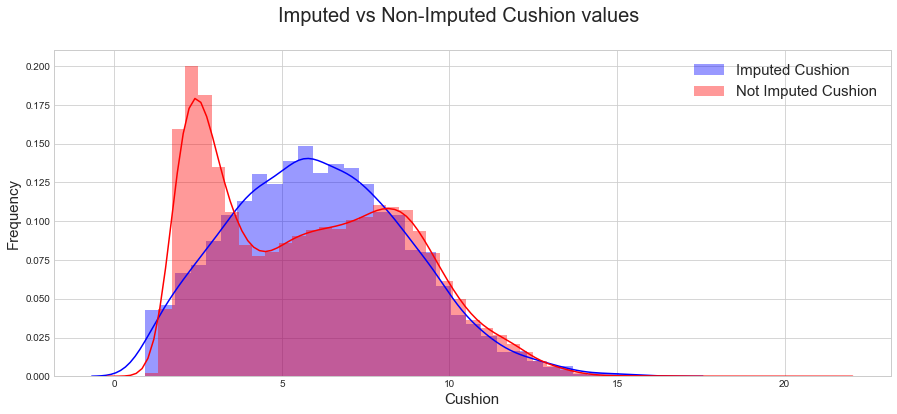

In [31]:
fig_dims = (15, 6)
fig, ax = plt.subplots(figsize=fig_dims)
fig.suptitle('Imputed vs Non-Imputed Cushion values', fontsize = 20)

sns.distplot(Missing_df['Cushion'] , color="blue", label="Imputed Cushion", hist = True)
sns.distplot(Not_Missing_df['Cushion'] , color="red", label="Not Imputed Cushion", hist = True)


ax.legend(prop={'size': 15})
ax.set_ylabel('Frequency', fontsize = 15)
A = ax.set_xlabel('Cushion', fontsize = 15) 

In [32]:
print('Mean cushion of all cushion values over 9 yards: ' + str(round(Over9['Cushion'].mean(), 2)))
print('Mean cushion of imputed values: ' + str(round(Missing_df['Cushion'].mean(), 2)))
print('Mean cushion of non-imputed values: ' + str(round(Not_Missing_df['Cushion'].mean(), 2)))


Mean cushion of all cushion values over 9 yards: 10.41
Mean cushion of imputed values: 6.14
Mean cushion of non-imputed values: 5.85


The distribution of the imputed cushion values is starkly different than the rest of the dataset, but that is OK. The goal of the imputation was to capture the fact that the missingess of cushion values resembles large cushion values, and I believe this was successful. 

In [33]:
Merged = NB_Features.copy()
Merged['Separation'] = Target

## Handling Outliers

Looking at the table below, I can see some problematic values. EZ_Dist, Receiver_Dist_From_Sideline, and Air Time all have negative values that are worth looking into. 

In [34]:
Merged[['EZ_Dist','Receiver_Dist_From_Sideline','Air_Time']].describe()

,EZ_Dist,Receiver_Dist_From_Sideline,Air_Time
count,43755.000000,43755.000000,43755.000000
mean,38.456989,13.078547,1.092687
std,15.302036,7.583634,0.570443
min,-3.640000,-5.466669,-0.167000
25%,28.910004,6.280000,0.697000
50%,41.430000,13.710000,0.902000
75%,50.739998,19.243330,1.320000
max,60.000000,26.663330,4.586000


'Air_Time' (time from pass being launched to pass arrival) has a minumum value of -0.167, and since time cannot be negative, I will drop all rows with negative time values. 

'EZ_Dist' (dist from receiver to back of endzone) can be negative because receievers can catch the ball with their pads (thats where the spatial data comes from) out of bounds, but defenders have no reason to guard receivers that are WAY out the back of the endzone, so it's worth seeing what is possible.

'Receiver_Dist_From_Sideline' can also be negative, but similar to EZ_Dist, some distances out of bounds are unrealistic and won't help with predictions

In [35]:
#Create Dataframe just for completions
Completed = df[df['Cmp'] == 1]

#Find the lowest possible EZ and Sideline distance
min_EZ_dist = min(Completed['EZ_Dist'])
min_Sideline_dist = round(min(Completed['Receiver_Dist_From_Sideline']), 1)
print('The furthest out of bounds a pass has been completed is', min_Sideline_dist, 'yards')
print('The furthest out the back of the endzone a pass has been completed is', min_EZ_dist, 'yards')

The furthest out of bounds a pass has been completed is -1.2 yards
The furthest out the back of the endzone a pass has been completed is -0.02 yards


Based on the above, for un I am going to remove all rows with recievers more than 1.5 yards out of bounds (1.2 + some room for new results in the future), and .5 yards out the back of the endzone. 

In [36]:
Merged = Merged[Merged['Air_Time'] > 0]
Merged = Merged[Merged['Receiver_Dist_From_Sideline'] > -1.5]
Merged = Merged[Merged['EZ_Dist'] > -.5]
print(len(Merged))
print('We dropped a total of 147 plays')

43607
We dropped a total of 147 plays


In [37]:
#Bring the Time Feature back, it was dropped earlier to create the imputations
Time_Index = Merged.index
Merged['Time'] = df['Time'][Time_Index]

Merged.columns

Index(['Nearest_Def_Position', 'Qtr', 'Time', 'Down', 'To Go',
       'Receiver_Location', 'Cushion', 'Air_Yds', 'Air_Dist', 'Air_Time',
       'TTT', 'QB_Separation', 'QBP', 'Receiver_Dist_From_Sideline', 'EZ_Dist',
       'missing_cushion', 'Separation'],
      dtype='object')

## Export Data to Pickle file

In [38]:
Merged.to_pickle("../data/trainable.pkl")